In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Set seed for reproducibility
np.random.seed(42)

# Generate timestamp data for 1 week at 1-minute intervals
time_index = pd.date_range('2023-01-01', periods=10080, freq='T')

# Generate temperature, pressure, and water level data with random noise
temperature = np.random.normal(loc=70, scale=5, size=len(time_index))
pressure = np.random.normal(loc=100, scale=10, size=len(time_index))
water_level = np.random.normal(loc=50, scale=5, size=len(time_index))

# Add missing sensor measurements due to connectivity issues
missing_prob = 0.05 # probability of a measurement being missing
for i in range(len(time_index)):
    if random.random() < missing_prob:
        temperature[i] = np.nan
    if random.random() < missing_prob:
        pressure[i] = np.nan
    if random.random() < missing_prob:
        water_level[i] = np.nan

# Add faulty measurements at random times and periods
faulty_index = random.sample(range(len(time_index)), 50)
temperature[faulty_index] = 80
pressure[faulty_index] = 120
water_level[faulty_index] = 60

# Generate machine status data randomly, with 25% chance for each state
machine_status = np.random.choice(['Running', 'Idle', 'Off', 'Failure'], size=len(time_index), p=[0.5, 0.20, 0.10, 0.20])

# Create a pandas DataFrame to store the generated data
data = pd.DataFrame({'timestamp': time_index,
                     'temperature': temperature,
                     'pressure': pressure,
                     'water_level': water_level,
                     'machine_status': machine_status})

# Add random noise to the measurements
noise_scale = 0.1 # scale of the noise
temperature += np.random.normal(loc=0, scale=noise_scale, size=len(time_index))
pressure += np.random.normal(loc=0, scale=noise_scale, size=len(time_index))
water_level += np.random.normal(loc=0, scale=noise_scale, size=len(time_index))

# Print the first few rows of the data
print(data.head())
data.to_csv('Machine_Data_final.csv')


            timestamp  temperature    pressure  water_level machine_status
0 2023-01-01 00:00:00    72.483571  118.486631          NaN        Running
1 2023-01-01 00:01:00    69.308678   86.923574    46.117284        Running
2 2023-01-01 00:02:00    73.238443  102.736601    53.731974        Failure
3 2023-01-01 00:03:00    77.615149  115.668547    51.326640        Running
4 2023-01-01 00:04:00    68.829233         NaN    48.298024        Running


In [11]:
df = pd.read_csv('Machine_Data_final.csv')
df = df.drop('Unnamed: 0',axis=1)
df

,timestamp,temperature,pressure,water_level,machine_status
0,2023-01-01 00:00:00,72.483571,118.486631,NaN,Running
1,2023-01-01 00:01:00,69.308678,86.923574,46.117284,Running
2,2023-01-01 00:02:00,73.238443,102.736601,53.731974,Failure
3,2023-01-01 00:03:00,77.615149,115.668547,51.326640,Running
4,2023-01-01 00:04:00,68.829233,NaN,48.298024,Running
...,...,...,...,...,...
10075,2023-01-07 23:55:00,68.448019,111.135214,48.000193,Running
10076,2023-01-07 23:56:00,66.715823,93.536827,56.803056,Running
10077,2023-01-07 23:57:00,64.608425,NaN,NaN,Running
10078,2023-01-07 23:58:00,71.794588,NaN,52.582925,Off


In [12]:
df.describe()

,temperature,pressure,water_level
count,9582.000000,9601.000000,9593.000000
mean,70.042656,100.242058,49.998273
std,5.043623,10.114889,4.990037
min,50.387999,61.436247,31.724567
25%,66.691374,93.383101,46.559956
50%,70.036353,100.189991,50.013114
75%,73.409272,107.074872,53.372496
max,89.631189,144.790843,68.458123


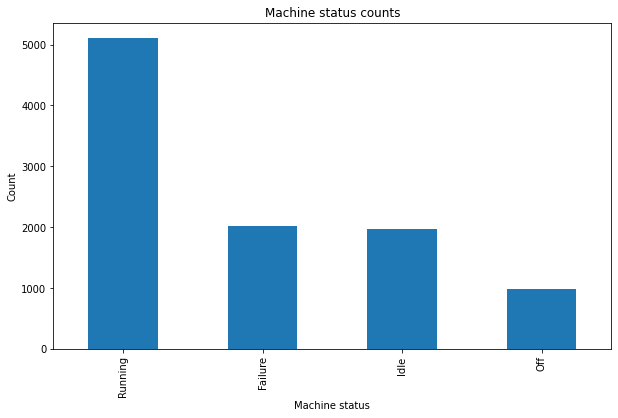

In [13]:
# a bar chart of machine status counts
fig, ax = plt.subplots(figsize=(10, 6))
df['machine_status'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('Machine status')
ax.set_ylabel('Count')
ax.set_title('Machine status counts')
plt.show()

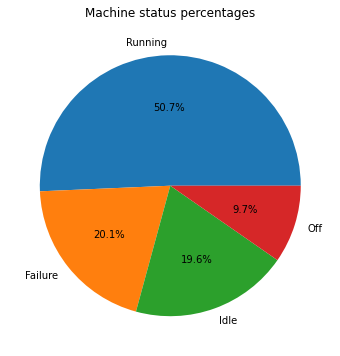

In [ ]:
# a pie chart of machine status percentages
fig, ax = plt.subplots(figsize=(10, 6))
df['machine_status'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_ylabel('')
ax.set_title('Machine status percentages')
plt.show()


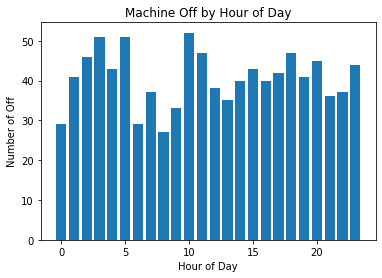

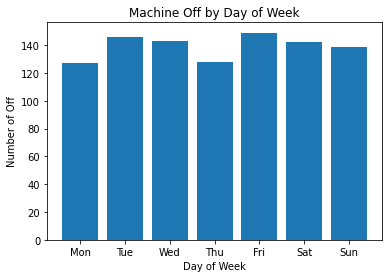

In [ ]:
# Extract hour of day and day of week from the timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Group by hour of day and count the number of failures
failures_by_hour = df[df['machine_status'] == 'Off'].groupby('hour').size()

# Plot the frequency of machine failures by hour
plt.bar(failures_by_hour.index, failures_by_hour.values)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Off')
plt.title('Machine Off by Hour of Day')
plt.show()

# Group by day of week and count the number of failures
failures_by_day = df[df['machine_status'] == 'Off'].groupby('day_of_week').size()

# Plot the frequency of machine failures by day of week
plt.bar(failures_by_day.index, failures_by_day.values)
plt.xlabel('Day of Week')
plt.ylabel('Number of Off')
plt.title('Machine Off by Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


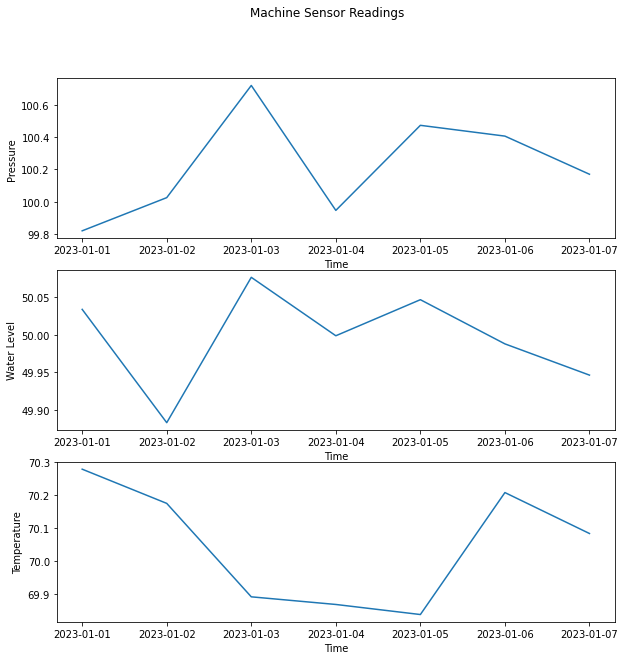

In [ ]:
df.set_index('timestamp', inplace=True)
daily_temps = df.resample('D').mean()


# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot pressure on the first subplot
axs[0].plot(daily_temps.index, daily_temps['pressure'])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Pressure')

# Plot water level on the second subplot
axs[1].plot(daily_temps.index, daily_temps['water_level'])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Water Level')

# Plot temperature on the third subplot
axs[2].plot(daily_temps.index, daily_temps['temperature'])
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Temperature')

# Set the title of the figure
fig.suptitle('Machine Sensor Readings')

# Display the figure
plt.show()



In [ ]:
# Group the data by day and machine status
daily_status_counts = df.groupby([df.index.date, 'machine_status'])['machine_status'].count()

# Convert the groupby object to a DataFrame
daily_status_counts = daily_status_counts.to_frame(name='count').reset_index()

# Filter only the rows where machine_status is 'Failure'
daily_failure_counts = daily_status_counts[daily_status_counts['machine_status'] == 'Failure']
print(daily_failure_counts)
# Group the data by day and count the number of failures for each day
daily_failure_counts = daily_failure_counts.groupby(daily_failure_counts['level_0'])['count'].sum()

# Find the day with the most failures
max_failures_day = daily_failure_counts.idxmax()

print("The day with the most failures is:", max_failures_day)


       level_0 machine_status  count
0   2023-01-01        Failure    284
4   2023-01-02        Failure    301
8   2023-01-03        Failure    303
12  2023-01-04        Failure    267
16  2023-01-05        Failure    301
20  2023-01-06        Failure    273
24  2023-01-07        Failure    295
The day with the most failures is: 2023-01-03


In [16]:
df = df.fillna(df.mean())

<ipython-input-16-04e87d67d337>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [17]:
# define the feature and target columns
features = ['temperature', 'pressure', 'water_level']
target = 'machine_status'

# create a binary target column indicating whether the machine is in failure status or not
df['Failure'] = df['machine_status'].apply(lambda x: 1 if x == 'Failure' else 0)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Failure'], test_size=0.8, random_state=42)

# create a logistic regression model
model = LogisticRegression()

# train the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)



# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# evaluate the confusion matrix of the model
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion)


# calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred,zero_division=1)
recall = recall_score(y_test, y_pred,zero_division=1)
f1 = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8040674603174603
Confusion Matrix:
 [[6484    0]
 [1580    0]]
Precision: 1.0
Recall: 0.0
F1-score: 0.0


In [18]:
# Import necessary libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Instantiate oversampler and undersampler objects
oversampler = RandomOverSampler(sampling_strategy='minority')
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Perform oversampling on the training data
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)


# create a logistic regression model
model = LogisticRegression()

# train the model on the training data
model.fit(X_train_over, y_train_over)

# make predictions on the testing data
y_pred_over = model.predict(X_test)


# evaluate the accuracy of the model
accuracy_over = accuracy_score(y_test, y_pred_over)
print('Accuracy:', accuracy_over)


# evaluate the confusion matrix of the model
confusion_over = confusion_matrix(y_test, y_pred_over)
print('Confusion Matrix:\n', confusion_over)


# calculate precision, recall, and F1-score
precision_over = precision_score(y_test, y_pred_over,zero_division=1)
recall_over = recall_score(y_test, y_pred_over)
f1_over = f1_score(y_test, y_pred_over)
print('Precision:', precision_over)
print('Recall:', recall_over)
print('F1-score:', f1_over)

Accuracy: 0.5095486111111112
Confusion Matrix:
 [[3322 3162]
 [ 793  787]]
Precision: 0.19929095973664218
Recall: 0.4981012658227848
F1-score: 0.284680774100199


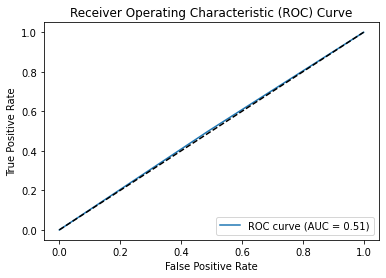

In [19]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_over)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_over)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Create a binary target column indicating whether the machine is in failure status or not
df['Failure'] = df['machine_status'].apply(lambda x: 1 if x == 'Failure' else 0)

# Create a new DataFrame containing only the relevant columns
df_corr = df[features + ['Failure']]

# Calculate the correlation matrix
corr_matrix = df_corr.corr()

# Print the correlation coefficients for the Failure column
print(corr_matrix['Failure'])


temperature   -0.009985
pressure      -0.004389
water_level   -0.002856
Failure        1.000000
Name: Failure, dtype: float64


                temperature  pressure  water_level  status_Failure  \
temperature        1.000000  0.011523     0.020243       -0.015417   
pressure           0.011523  1.000000     0.019938       -0.009680   
water_level        0.020243  0.019938     1.000000       -0.008764   
status_Failure    -0.015417 -0.009680    -0.008764        1.000000   
status_Idle        0.009048  0.005232     0.009212       -0.247274   
status_Off         0.006619  0.006909    -0.008232       -0.163931   
status_Running     0.001261 -0.000478     0.004576       -0.508150   

                status_Idle  status_Off  status_Running  
temperature        0.009048    0.006619        0.001261  
pressure           0.005232    0.006909       -0.000478  
water_level        0.009212   -0.008232        0.004576  
status_Failure    -0.247274   -0.163931       -0.508150  
status_Idle        1.000000   -0.161343       -0.500126  
status_Off        -0.161343    1.000000       -0.331560  
status_Running    -0.500126   -0.

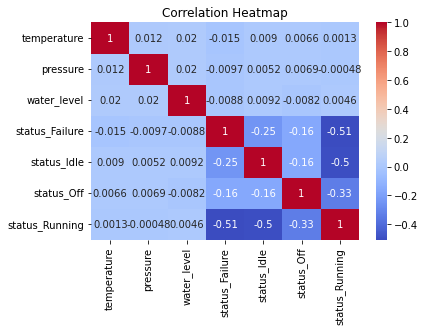

In [24]:
# Perform one-hot encoding on the machine_status column
machine_status_encoded = pd.get_dummies(df['machine_status'], prefix='status')

# Combine the encoded variables with the original DataFrame
df_encoded = pd.concat([df, machine_status_encoded], axis=1)
df_encoded= df_encoded.drop(['Failure'],axis=1)
# Create the correlation matrix
corr_matrix = df_encoded.corr()
print(corr_matrix)
# Create the heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

# Set the title of the heatmap
plt.title("Correlation Heatmap")

# Show the plot
plt.show()


In [ ]:
# create a list to store the number of consecutive running status
running_status_counts = []

# initialize a counter for consecutive running status
count = 0

# iterate over the machine_status column
for status in df['machine_status']:
    if status == 'Running':
        # if status is running, increment the counter
        count += 1
    else:
        # if status is not running, append the count to the list and reset the counter
        running_status_counts.append(count)
        count = 0

# find the maximum number of consecutive running status before a failure occurs
max_running_status = max(running_status_counts)

print("The maximum number of consecutive running status before a failure occurs is:", max_running_status)



The maximum number of consecutive running status before a failure occurs is: 14
